# Final Project -- Data Analysis on IBM HR Analytics Attrition and Performance

Name: *Cindy Miao, Haiying Lin, Susie Liang*

Due Date: *03 / 22 / 24*

In [1]:
# Enviroment
versioninfo()

Julia Version 1.10.0
Commit 3120989f39 (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 8 × Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, icelake-client)
  Threads: 1 on 8 virtual cores
Environment:
  JULIA_NUM_THREADS = 


In [2]:
import Pkg
Pkg.activate(dirname("c:\\Users\\mcy12\\OneDrive\\Desktop\\UCR\\Winter 2024\\Stat 206\\Discussion"))
Pkg.status()

  Activating project at `c:\Users\mcy12\OneDrive\Desktop\UCR\Winter 2024\Stat 206`


Status `C:\Users\mcy12\OneDrive\Desktop\UCR\Winter 2024\Stat 206\Project.toml`
  [336ed68f] CSV v0.10.13
  [052768ef] CUDA v5.2.0
  [13f3f980] CairoMakie v0.11.9
  [324d7699] CategoricalArrays v0.10.8
  [aaaa29a8] Clustering v0.15.7
  [a93c6f00] DataFrames v1.6.1
  [b4f34e82] Distances v0.10.11
  [31c24e10] Distributions v0.25.107
  [97725368] EncodedArrays v0.3.2
⌃ [587475ba] Flux v0.14.13
  [38e38edf] GLM v1.9.0
  [8d5ece8b] GLMNet v0.7.2
  [09f84164] HypothesisTests v0.11.0
  [7073ff75] IJulia v1.24.2
  [4e3cecfd] ImageShow v0.3.8
  [b964fa9f] LaTeXStrings v1.3.1
  [b4fcebef] Lasso v0.7.1
  [f0e99cf1] MLBase v0.9.2
  [cc2ba9b6] MLDataUtils v0.5.4
  [eb30cadb] MLDatasets v0.7.14
⌃ [add582a8] MLJ v0.20.0
⌃ [a7f614a8] MLJBase v1.1.2
  [d354fa79] MLJClusteringInterface v0.1.11
  [094fc8d1] MLJFlux v0.4.0
  [caf8df21] MLJGLMInterface v0.3.7
  [6ee0df7b] MLJLinearModels v0.10.0
  [1b6a4a23] MLJMultivariateStatsInterface v0.5.3
  [6f286f6a] MultivariateStats v0.10.2
  [636a865e] NearestNei

In [3]:
# packages used for the project
using CSV, DataFrames, Statistics, StatsBase, Plots, StatsPlots, Random, StableRNGs
using MLDataUtils, MLBase
using GLM, GLMNet
using CategoricalArrays
using MLJ, MLJFlux, MLJLinearModels, MLJMultivariateStatsInterface 
using NearestNeighborModels
using ROCAnalysis
using CairoMakie

#### Data Cleaning

In [98]:
IBM_Employee = CSV.read("WA_Fn-UseC_-HR-Employee-Attrition.csv", DataFrame, stringtype = String)
first(IBM_Employee, 5)

5×35 DataFrame
 Row │ Age    Attrition  BusinessTravel     DailyRate  Department              ⋯
     │ Int64  String     String             Int64      String                  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    41  Yes        Travel_Rarely           1102  Sales                   ⋯
   2 │    49  No         Travel_Frequently        279  Research & Development
   3 │    37  Yes        Travel_Rarely           1373  Research & Development
   4 │    33  No         Travel_Frequently       1392  Research & Development
   5 │    27  No         Travel_Rarely            591  Research & Development  ⋯
                                                              30 columns omitted

In [99]:
# remove the unnecessary categories: EmployeeCount, EmployeeNumber,Over18, and StandardHours, left 31 variables
IBM_Employee = select(IBM_Employee, Not([:EmployeeCount, :EmployeeNumber, :Over18, :StandardHours]))
first(IBM_Employee, 5)

5×31 DataFrame
 Row │ Age    Attrition  BusinessTravel     DailyRate  Department              ⋯
     │ Int64  String     String             Int64      String                  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    41  Yes        Travel_Rarely           1102  Sales                   ⋯
   2 │    49  No         Travel_Frequently        279  Research & Development
   3 │    37  Yes        Travel_Rarely           1373  Research & Development
   4 │    33  No         Travel_Frequently       1392  Research & Development
   5 │    27  No         Travel_Rarely            591  Research & Development  ⋯
                                                              26 columns omitted

In [ ]:
IBM = copy(IBM_Employee);  # copy of original dataset for later use

In [100]:
# Change Attrition to factors "Yes" = 1 & "No" = 0
IBM_Employee.Attrition = map(x -> x == "Yes" ? 1 : 0, IBM_Employee.Attrition)
first(IBM_Employee, 5)

5×31 DataFrame
 Row │ Age    Attrition  BusinessTravel     DailyRate  Department              ⋯
     │ Int64  Int64      String             Int64      String                  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    41          1  Travel_Rarely           1102  Sales                   ⋯
   2 │    49          0  Travel_Frequently        279  Research & Development
   3 │    37          1  Travel_Rarely           1373  Research & Development
   4 │    33          0  Travel_Frequently       1392  Research & Development
   5 │    27          0  Travel_Rarely            591  Research & Development  ⋯
                                                              26 columns omitted

#### Exploratory Data Analysis

***Data Summaries***

In [7]:
describe(IBM_Employee, :mean, :std, :min, :max, :q25, :median, :q75, :nmissing, :eltype)

31×10 DataFrame
 Row │ variable                  mean      std       min              max      ⋯
     │ Symbol                    Union…    Union…    Any              Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Age                       36.9238   9.13537   18               60       ⋯
   2 │ Attrition                 0.161224  0.367863  0                1
   3 │ BusinessTravel                                Non-Travel       Travel_R
   4 │ DailyRate                 802.486   403.509   102              1499
   5 │ Department                                    Human Resources  Sales    ⋯
   6 │ DistanceFromHome          9.19252   8.10686   1                29
   7 │ Education                 2.91293   1.02416   1                5
   8 │ EducationField                                Human Resources  Technica
  ⋮  │            ⋮                 ⋮         ⋮             ⋮                ⋮ ⋱
  25 │ TotalWorkingYears         11.2796   7.78078   0                40       ⋯
  26 │ TrainingTimesLastYear     2.79932   1.28927   0                6
  27 │ WorkLifeBalance           2.76122   0.706476  1                4
  28 │ YearsAtCompany            7.00816   6.12653   0                40
  29 │ YearsInCurrentRole        4.22925   3.62314   0                18       ⋯
  30 │ YearsSinceLastPromotion   2.18776   3.22243   0                15
  31 │ YearsWithCurrManager      4.12313   3.56814   0                17
                                                   6 columns and 16 rows omitted

***Correlation Matrix***

In [8]:
# select all variables with type integer 
numerical_cols = select(IBM_Employee, names(IBM_Employee, Int64))
# Compute the correlation matrix
cor_matrix = cor(Matrix(numerical_cols));

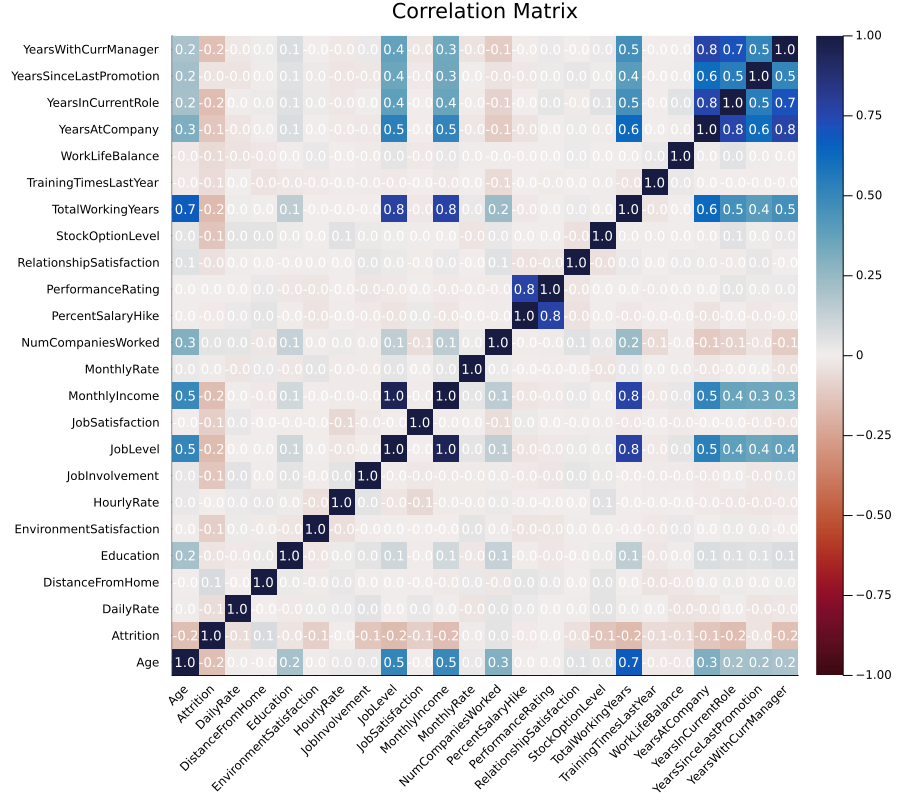

In [9]:
# plot the correlation matrix
vars = names(numerical_cols)[1:24]
fig = StatsPlots.heatmap(cor_matrix,
  title = "Correlation Matrix",
  clims = (-1, 1),
  xticks = (1:24, vars),
  yticks = (1:24, vars),
  color = cgrad(:balance, rev = true),
  xrot = 45,
  aspect = :ratio,
  size = (900, 800),
)
for j in axes(cor_matrix, 2), i in axes(cor_matrix, 1)
  annotate!(i, j, StatsPlots.text("$(round(cor_matrix[i,j], digits = 1))", :white, 9))
end
fig

***Attrition Distribution***

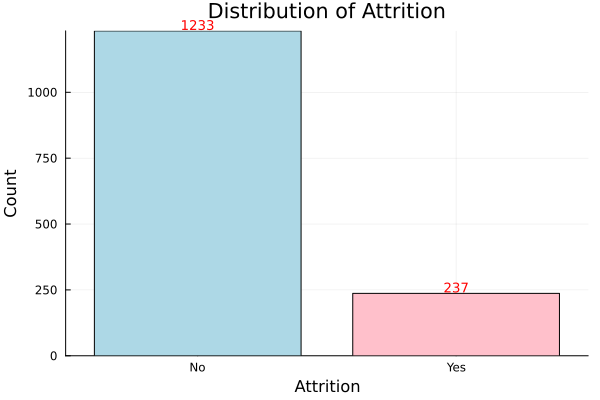

In [10]:
# Count the number of occurrences for each level of Attrition
attrition_counts = countmap(IBM_Employee[!, :Attrition])

# Extract the counts for '0' and '1' ensuring we have a count for each, even if missing
no_attrition_count = get(attrition_counts, 0, 0)
yes_attrition_count = get(attrition_counts, 1, 0)

colors = ["#ADD8E6", "#FFC0CB"]

# Create a bar chart and assign it to a variable
p = bar(["No", "Yes"], [no_attrition_count, yes_attrition_count], color=colors, legend=false)

# Annotate counts above bars
annotate!(p, [(0.5, no_attrition_count + 22, StatsPlots.text(string(no_attrition_count), :center, 9, :red)),
              (1.5, yes_attrition_count + 22, StatsPlots.text(string(yes_attrition_count), :center, 9, :red))])

# Customize the plot
StatsPlots.xlabel!(p, "Attrition")
StatsPlots.ylabel!(p, "Count")
title!(p, "Distribution of Attrition")
display(p)

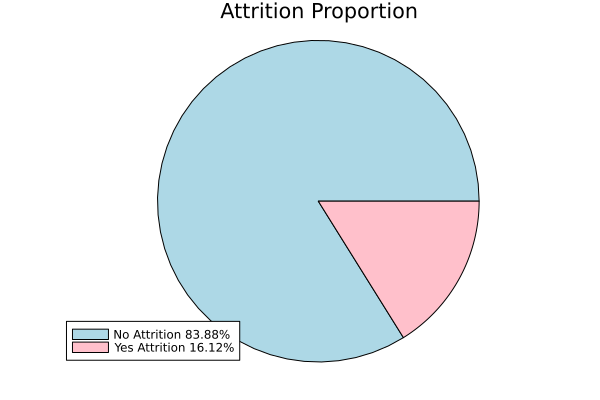

In [11]:
# Calculate proportions for the pie chart
total_count = no_attrition_count + yes_attrition_count
proportions = [no_attrition_count / total_count, yes_attrition_count / total_count]

# Create the pie chart with labels showing the proportions
labels = ["No Attrition $(round(proportions[1]*100; digits=2))%", "Yes Attrition $(round(proportions[2]*100; digits=2))%"]
p = StatsPlots.pie(labels, proportions, legend=:bottomleft, color=["#ADD8E6", "#FFC0CB"])

title!("Attrition Proportion")
display(p)


***Attrition vs. Age***

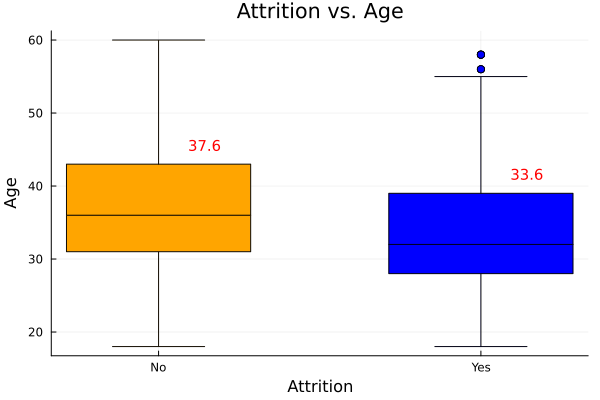

In [12]:
# Convert Attrition to a string for plotting purposes
IBM_Employee[!, :Attrition] = string.(IBM_Employee[!, :Attrition])

# Replace "0" with "No" and "1" with "Yes" for clear plotting
IBM_Employee[!, :Attrition] = replace.(IBM_Employee[!, :Attrition], "0" => "No", "1" => "Yes")

col = [:orange :blue]
# Create the box plot with separate colors for "No" and "Yes"
p = StatsPlots.boxplot(IBM_Employee[!, :Attrition], IBM_Employee[!, :Age], 
            group=IBM_Employee[!, :Attrition], legend=false, color=[:orange :blue],
            ylabel="Age", xlabel="Attrition", title="Attrition vs. Age")
            
# Calculate the mean age for 'No' and 'Yes' groups
mean_age_no = mean(IBM_Employee[IBM_Employee[!, :Attrition] .== "No", :Age])
mean_age_yes = mean(IBM_Employee[IBM_Employee[!, :Attrition] .== "Yes", :Age])

# Adding text annotations for the mean ages at an offset above the means
y_offset = 8  # This is an arbitrary offset for display purposes, adjust as needed.
annotate!([(1 - 0.3, mean_age_no + y_offset, StatsPlots.text(round(mean_age_no, digits=1), :center, 10, :red)),
           (2.1, mean_age_yes + y_offset, StatsPlots.text(round(mean_age_yes, digits=1), :center, 10, :red))])

# Display the boxplot with the mean annotations
display(p)

***Attrition vs. Gender***

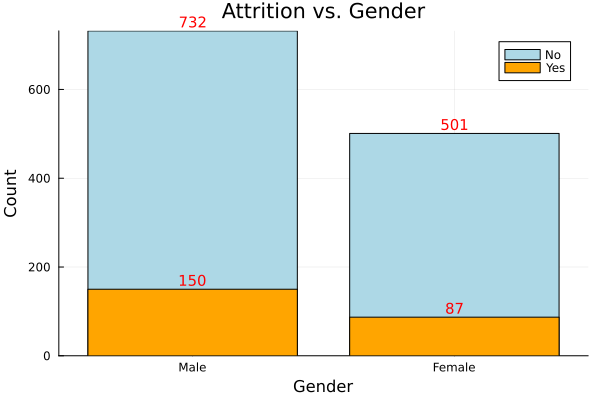

In [13]:
# Group data by 'Gender' and 'Attrition' and then count the occurrences
grouped_data = groupby(IBM_Employee, [:Gender, :Attrition])
count_data = combine(grouped_data, nrow => :count)

# Separate the counts for female and male
female_counts = count_data[count_data.Gender .== "Female", :]
male_counts = count_data[count_data.Gender .== "Male", :]

# Plot the bar chart with labels showing the counts
bar_chart = StatsPlots.bar(count_data[!, :Gender], count_data[!, :count],
                group=count_data[!, :Attrition],
                color=[:lightblue :orange],
                ylabel="Count", xlabel="Gender", title="Attrition vs. Gender",
                labels=["No" "Yes"])  
 
# Annotate counts above bars
annotate!(1.5, female_counts[1, :count] + 20, StatsPlots.text(string(female_counts[1, :count]), :center, 10, :red))
annotate!(1.5, female_counts[2, :count] + 20, StatsPlots.text(string(female_counts[2, :count]), :center, 10, :red))
annotate!(0.5, male_counts[1, :count] + 20, StatsPlots.text(string(male_counts[1, :count]), :center, 10, :red))
annotate!(0.5, male_counts[2, :count] + 20, StatsPlots.text(string(male_counts[2, :count]), :center, 10, :red))

# Display the bar chart
display(bar_chart)

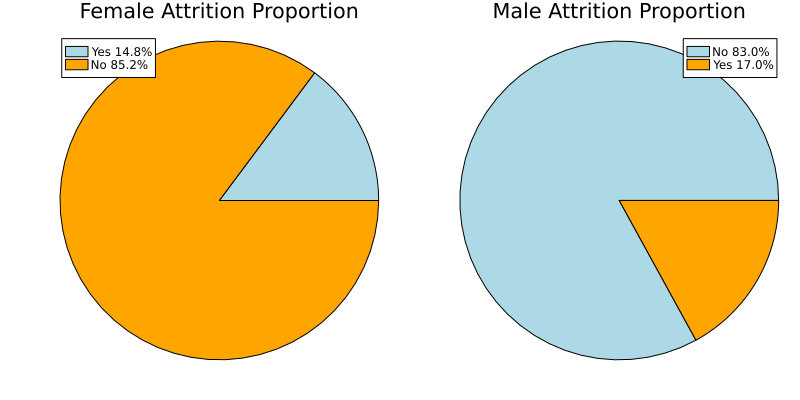

In [14]:
# Calculate proportions for the pie chart
female_total = sum(female_counts.count)
male_total = sum(male_counts.count)

female_proportions = female_counts.count / female_total
male_proportions = male_counts.count / male_total

# Create the pie chart with labels showing the proportions
female_labels = ["Yes $(round(female_proportions[1]*100; digits=1))%", "No $(round(female_proportions[2]*100; digits=1))%"]
male_labels = ["No $(round(male_proportions[1]*100; digits=1))%", "Yes $(round(male_proportions[2]*100; digits=1))%"]

# Create pie charts
plot_pie_gender = StatsPlots.plot(layout = (1, 2), size=(800, 400))

StatsPlots.pie!(plot_pie_gender, female_labels, female_proportions, color=[:lightblue, :orange], title="Female Attrition Proportion")
StatsPlots.pie!(plot_pie_gender[2], male_labels, male_proportions, color=[:lightblue, :orange], title="Male Attrition Proportion")

display(plot_pie_gender)

***Attrition vs. Business Travel Frequency***

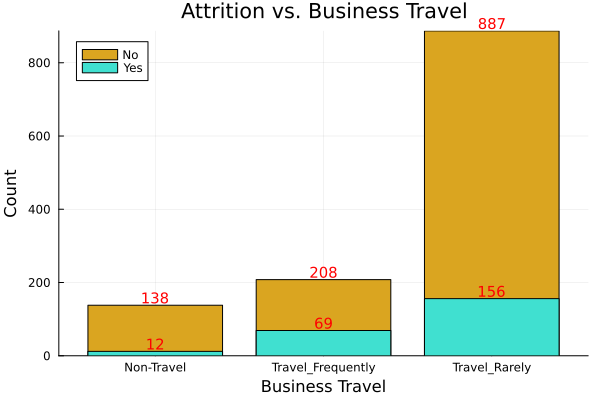

In [15]:
# Group data by 'BusinessTravel' and 'Attrition' and then count the occurrences
grouped_data = groupby(IBM_Employee, [:BusinessTravel, :Attrition])
count_data = combine(grouped_data, nrow => :count)

# Sort the data to ensure consistent plotting
sort!(count_data, [:BusinessTravel, :Attrition])

# Extract the labels for each bar which are the counts
bar_labels = string.(count_data[:, :count])

# Plot the bar chart with labels showing the counts
bar_chart = StatsPlots.bar(count_data[!, :BusinessTravel], count_data[!, :count],
                group=count_data[!, :Attrition],
                color=[:goldenrod :turquoise], legend=:topleft,
                ylabel="Count", xlabel="Business Travel", title="Attrition vs. Business Travel",
                label=["No" "Yes"])

# Annotate counts above bars
# Non-Travel labels
annotate!(0.5, count_data[1, :count] + 20, StatsPlots.text(string(count_data[1, :count]), :center, 10, :red))
annotate!(0.5, count_data[2, :count] + 20, StatsPlots.text(string(count_data[2, :count]), :center, 10, :red))
# Travel-Frequently labels
annotate!(1.5, count_data[3, :count] + 20, StatsPlots.text(string(count_data[3, :count]), :center, 10, :red))
annotate!(1.5, count_data[4, :count] + 20, StatsPlots.text(string(count_data[4, :count]), :center, 10, :red))
# Travel-Rarely labels
annotate!(2.5, count_data[5, :count] + 20, StatsPlots.text(string(count_data[5, :count]), :center, 10, :red))
annotate!(2.5, count_data[6, :count] + 20, StatsPlots.text(string(count_data[6, :count]), :center, 10, :red))

# Display the bar chart
display(bar_chart)

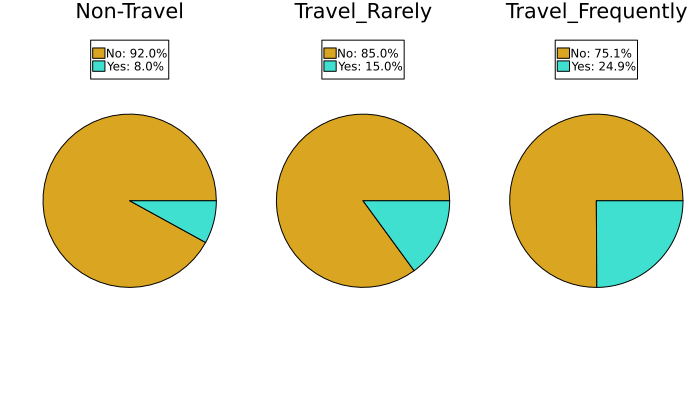

In [16]:
# Create a DataFrame to hold the pie chart data
pie_data = DataFrame(BusinessTravel = String[], Attrition = String[], Proportion = Float64[], Label = String[])

# Calculate proportions and labels for each business travel category
for bt in unique(IBM_Employee[!, :BusinessTravel])
    # Filter count_data for each BusinessTravel category
    bt_data = count_data[count_data[!, :BusinessTravel] .== bt, :]
    
    total = sum(bt_data[!, :count])
    for row in eachrow(bt_data)
        prop = row.count / total
        label = "$(row.Attrition == "Yes" ? "Yes" : "No"): $(round(prop * 100, digits=1))%"
        push!(pie_data, (bt, row.Attrition, prop, label))
    end
end

# Function to generate a pie chart for a specific BusinessTravel category
function generate_pie_chart(data, category)
    cat_data = data[data[!, :BusinessTravel] .== category, :]
    StatsPlots.pie(cat_data[!, :Label], cat_data[!, :Proportion], color=[:goldenrod, :turquoise], legend = :top, title=category)
end

# Generate pie charts for each BusinessTravel category
p1 = generate_pie_chart(pie_data, "Non-Travel")
p2 = generate_pie_chart(pie_data, "Travel_Rarely")
p3 = generate_pie_chart(pie_data, "Travel_Frequently")

# Combine pie charts into a single figure
pie_charts = StatsPlots.plot(p1, p2, p3, layout=(1, 3), size = (700, 400))

# Display pie charts
display(pie_charts)

***Attrition vs. Department***

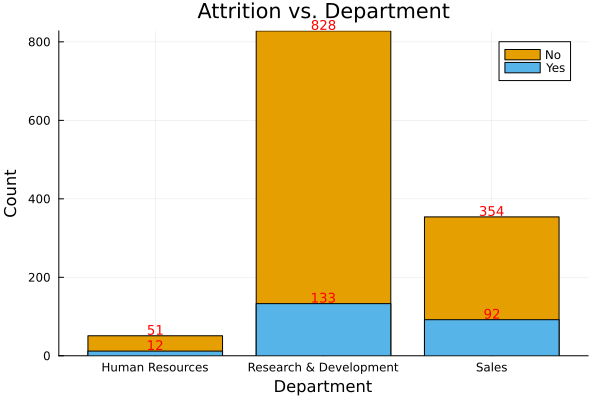

In [17]:
# Group data by 'Department' and 'Attrition' and then count the occurrences
grouped_data = groupby(IBM_Employee, [:Department, :Attrition])
count_data = combine(grouped_data, nrow => :count)

# Sort the data to ensure consistent plotting
sort!(count_data, [:Department, :Attrition])

# Create bar chart
bar_chart = StatsPlots.bar(count_data[!, :Department], count_data[!, :count],
                group=count_data[!, :Attrition],
                color=["#E69F00" "#56B4E9"], legend=:topright,
                ylabel="Count", xlabel="Department", title="Attrition vs. Department")

# Annotate counts on the bars
for (i, row) in enumerate(eachrow(count_data))
    annotate!(bar_chart, row[:Department], row[:count] + 15, StatsPlots.text(string(row[:count]), :center, 9, :red))
end

# Display the bar chart
display(bar_chart)

***Attrition vs. Education Field***

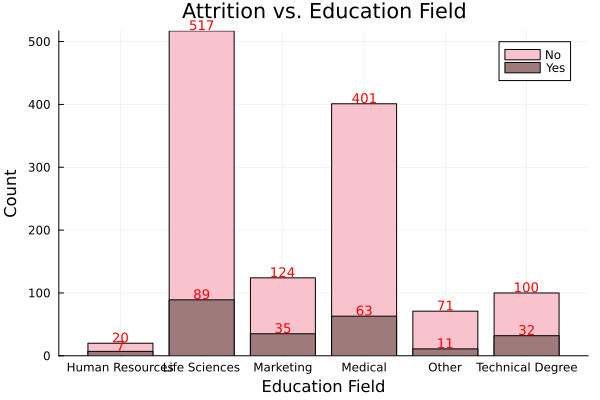

In [18]:
# Group data by 'EducationField' and 'Attrition' and then count the occurrences
grouped_data = groupby(IBM_Employee, [:EducationField, :Attrition])
count_data = combine(grouped_data, nrow => :count)

# Sort the data to ensure consistent plotting
sort!(count_data, [:EducationField, :Attrition])

# Create bar chart
bar_chart = StatsPlots.bar(count_data[!, :EducationField], count_data[!, :count],
                group=count_data[!, :Attrition],
                color=["#F8C3CD" "#9E7A7A"], legend=:topright,
                ylabel="Count", xlabel="Education Field", title="Attrition vs. Education Field")

# Annotate counts above the bars
for (i, row) in enumerate(eachrow(count_data))
    annotate!(bar_chart, (row[:EducationField], row[:count] + 9, StatsPlots.text(string(row[:count]), 9, :center, :red)))
end
# Display the bar chart
display(bar_chart)

***Attrition vs. Environment Satisfaction***

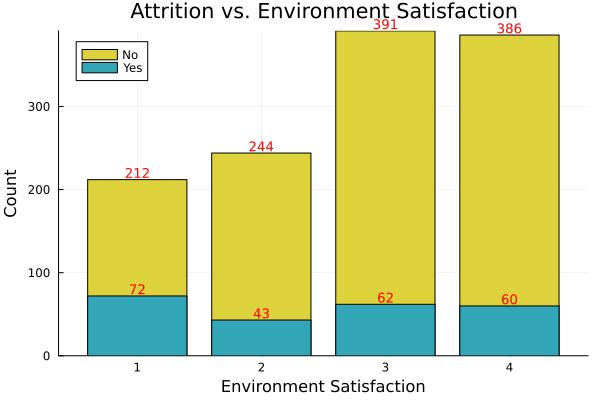

In [19]:
# Group data by 'EnvironmentSatisfaction' and 'Attrition' and then count the occurrences
grouped_data = groupby(IBM_Employee, [:EnvironmentSatisfaction, :Attrition])
count_data = combine(grouped_data, nrow => :count)

# Sort the data to ensure consistent plotting
sort!(count_data, [:EnvironmentSatisfaction, :Attrition])

# Create a bar chart
bar_chart = StatsPlots.bar(count_data[!, :EnvironmentSatisfaction], count_data[!, :count],
                group=count_data[!, :Attrition],
                color=["#DDD23B" "#33A6B8"], legend=:topleft,
                ylabel="Count", xlabel="Environment Satisfaction", title="Attrition vs. Environment Satisfaction")
# Annotate counts above the bars
for (i, row) in enumerate(eachrow(count_data))
    annotate!(bar_chart, (row[:EnvironmentSatisfaction], row[:count] + 8, StatsPlots.text(string(row[:count]), 9, :center, :red)))
end

# Display the bar chart
display(bar_chart)

#### Data Standardization

In [20]:
# select only numerical variables
numerical = select(numerical_cols, Not([:Age, :Attrition, :Education, :EnvironmentSatisfaction, :JobInvolvement, :JobLevel,
                                        :JobSatisfaction, :PerformanceRating, :RelationshipSatisfaction, 
                                        :StockOptionLevel, :WorkLifeBalance]))
# change into matrix for standarization                                      
numerical_matrix = Matrix(numerical)
# change type to float
numerical_matrix_float = float(numerical_matrix)

# summary of original numerical variables
describe(numerical, :mean, :std, :min, :median, :max, :nmissing, :eltype)

13×8 DataFrame
 Row │ variable                 mean         std         min    median   max   ⋯
     │ Symbol                   Float64      Float64     Int64  Float64  Int64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ DailyRate                  802.486     403.509      102    802.0   1499 ⋯
   2 │ DistanceFromHome             9.19252     8.10686      1      7.0     29
   3 │ HourlyRate                  65.8912     20.3294      30     66.0    100
   4 │ MonthlyIncome             6502.93     4707.96      1009   4919.0  19999
   5 │ MonthlyRate              14313.1      7117.79      2094  14235.5  26999 ⋯
   6 │ NumCompaniesWorked           2.6932      2.49801      0      2.0      9
   7 │ PercentSalaryHike           15.2095      3.65994     11     14.0     25
   8 │ TotalWorkingYears           11.2796      7.78078      0     10.0     40
   9 │ TrainingTimesLastYear        2.79932     1.28927      0      3.0      6 ⋯
  10 │ YearsAtCompany               7.00816     6.12653      0      5.0     40
  11 │ YearsInCurrentRole           4.22925     3.62314      0      3.0     18
  12 │ YearsSinceLastPromotion      2.18776     3.22243      0      1.0     15
  13 │ YearsWithCurrManager         4.12313     3.56814      0      3.0     17 ⋯
                                                               2 columns omitted

In [21]:
# use Zscore transform to standarize
dt = StatsBase.fit(ZScoreTransform, numerical_matrix_float; dims=1)
input_standardized = StatsBase.transform!(dt, numerical_matrix_float)

# Round the standardized values to two decimal places
input_standardized = round.(input_standardized, digits=2)

# change the standarized matrix back to DataFrame variables
input_standardized_df = DataFrame(input_standardized, :auto)
rename!(input_standardized_df, [:DailyRate, :DistanceFromHome, :HourlyRate,:MonthlyIncome,:MonthlyRate,:NumCompaniesWorked,
                             :PercentSalaryHike,:TotalWorkingYears, :TrainingTimesLastYear,:YearsAtCompany,
                             :YearsInCurrentRole,:YearsSinceLastPromotion,:YearsWithCurrManager])

first(input_standardized_df, 5)

5×13 DataFrame
 Row │ DailyRate  DistanceFromHome  HourlyRate  MonthlyIncome  MonthlyRate  Nu ⋯
     │ Float64    Float64           Float64     Float64        Float64      Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      0.74             -1.01        1.38          -0.11         0.73     ⋯
   2 │     -1.3              -0.15       -0.24          -0.29         1.49
   3 │      1.41             -0.89        1.28          -0.94        -1.67
   4 │      1.46             -0.76       -0.49          -0.76         1.24
   5 │     -0.52             -0.89       -1.27          -0.64         0.33     ⋯
                                                               8 columns omitted

In [22]:
# summaries after standarized
describe(input_standardized_df, :mean, :std, :min, :median, :max, :nmissing, :eltype)

13×8 DataFrame
 Row │ variable                 mean          std       min      median   max  ⋯
     │ Symbol                   Float64       Float64   Float64  Float64  Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ DailyRate                 6.80272e-5   0.999839    -1.74    0.0       1 ⋯
   2 │ DistanceFromHome          2.04082e-5   0.999998    -1.01   -0.27      2
   3 │ HourlyRate               -0.00014966   1.00027     -1.77    0.01      1
   4 │ MonthlyIncome            -0.000170068  1.00004     -1.17   -0.335     2
   5 │ MonthlyRate              -4.08163e-5   0.999885    -1.72   -0.01      1 ⋯
   6 │ NumCompaniesWorked       -0.00272109   0.999204    -1.08   -0.28      2
   7 │ PercentSalaryHike         0.000557823  1.00063     -1.15   -0.33      2
   8 │ TotalWorkingYears         0.000585034  0.999961    -1.45   -0.16      3
   9 │ TrainingTimesLastYear     0.00130612   1.00048     -2.17    0.16      2 ⋯
  10 │ YearsAtCompany            0.000598639  0.999726    -1.14   -0.33      5
  11 │ YearsInCurrentRole       -0.00214966   1.00068     -1.17   -0.34      3
  12 │ YearsSinceLastPromotion  -0.00157823   0.999759    -0.68   -0.37      3
  13 │ YearsWithCurrManager     -0.000170068  1.003       -1.16   -0.31      3 ⋯
                                                               3 columns omitted

In [23]:
# select only categorical variables from original data
category = select(IBM, Not([:DailyRate, :DistanceFromHome, :HourlyRate,:MonthlyIncome,:MonthlyRate,:NumCompaniesWorked,
                                     :PercentSalaryHike,:TotalWorkingYears, :TrainingTimesLastYear,:YearsAtCompany,
                                     :YearsInCurrentRole,:YearsSinceLastPromotion,:YearsWithCurrManager]))

# Combine standardized data and categorical data together
combined_IBM = hcat(input_standardized_df, category)

first(combined_IBM, 5)

5×31 DataFrame
 Row │ DailyRate  DistanceFromHome  HourlyRate  MonthlyIncome  MonthlyRate  Nu ⋯
     │ Float64    Float64           Float64     Float64        Float64      Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      0.74             -1.01        1.38          -0.11         0.73     ⋯
   2 │     -1.3              -0.15       -0.24          -0.29         1.49
   3 │      1.41             -0.89        1.28          -0.94        -1.67
   4 │      1.46             -0.76       -0.49          -0.76         1.24
   5 │     -0.52             -0.89       -1.27          -0.64         0.33     ⋯
                                                              26 columns omitted

#### Categorical Data Encoding

In [24]:
# change "Texual to Multiclass" for all categorical variables
update_IBM = coerce(combined_IBM, Dict(:BusinessTravel => Multiclass, :Department => Multiclass, :EducationField => Multiclass, 
                            :Gender => Multiclass, :JobRole => Multiclass, :MaritalStatus => Multiclass, :OverTime => Multiclass))
MLJ.schema(update_IBM)  

┌─────────────────────────┬───────────────┬──────────────────────────────────┐
│ names                   │ scitypes      │ types                            │
├─────────────────────────┼───────────────┼──────────────────────────────────┤
│ DailyRate               │ Continuous    │ Float64                          │
│ DistanceFromHome        │ Continuous    │ Float64                          │
│ HourlyRate              │ Continuous    │ Float64                          │
│ MonthlyIncome           │ Continuous    │ Float64                          │
│ MonthlyRate             │ Continuous    │ Float64                          │
│ NumCompaniesWorked      │ Continuous    │ Float64                          │
│ PercentSalaryHike       │ Continuous    │ Float64                          │
│ TotalWorkingYears       │ Continuous    │ Float64                          │
│ TrainingTimesLastYear   │ Continuous    │ Float64                          │
│ YearsAtCompany          │ Continuous    │ Float64 

In [25]:
# Encoding categorical variables
mach = machine(OneHotEncoder(), update_IBM) |> fit!
update_IBM = MLJ.transform(mach)

first(update_IBM, 5)

┌ Info: Training machine(OneHotEncoder(features = Symbol[], …), …).
└ @ MLJBase C:\Users\mcy12\.julia\packages\MLJBase\eCnWm\src\machines.jl:493
┌ Info: Spawning 3 sub-features to one-hot encode feature :BusinessTravel.
└ @ MLJModels C:\Users\mcy12\.julia\packages\MLJModels\55VdT\src\builtins\Transformers.jl:878
┌ Info: Spawning 3 sub-features to one-hot encode feature :Department.
└ @ MLJModels C:\Users\mcy12\.julia\packages\MLJModels\55VdT\src\builtins\Transformers.jl:878
┌ Info: Spawning 6 sub-features to one-hot encode feature :EducationField.
└ @ MLJModels C:\Users\mcy12\.julia\packages\MLJModels\55VdT\src\builtins\Transformers.jl:878
┌ Info: Spawning 2 sub-features to one-hot encode feature :Gender.
└ @ MLJModels C:\Users\mcy12\.julia\packages\MLJModels\55VdT\src\builtins\Transformers.jl:878
┌ Info: Spawning 9 sub-features to one-hot encode feature :JobRole.
└ @ MLJModels C:\Users\mcy12\.julia\packages\MLJModels\55VdT\src\builtins\Transformers.jl:878
┌ Info: Spawning 3 sub-featur

5×52 DataFrame
 Row │ DailyRate  DistanceFromHome  HourlyRate  MonthlyIncome  MonthlyRate  Nu ⋯
     │ Float64    Float64           Float64     Float64        Float64      Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      0.74             -1.01        1.38          -0.11         0.73     ⋯
   2 │     -1.3              -0.15       -0.24          -0.29         1.49
   3 │      1.41             -0.89        1.28          -0.94        -1.67
   4 │      1.46             -0.76       -0.49          -0.76         1.24
   5 │     -0.52             -0.89       -1.27          -0.64         0.33     ⋯
                                                              47 columns omitted

#### Lasso Variable Selection

In [26]:
# Set the random seed to 206
Random.seed!(206)

# Specify the proportion of data to use for training
train_proportion = 0.7
# Split the data into train and test sets
(train_data, test_data) = splitobs(shuffleobs(update_IBM), at = train_proportion)

# predict and response variables of train data
X_train = Matrix(select(train_data, Not([:Attrition])))  
y_train = convert(Vector, train_data.Attrition)

# predict and response variables of test data
X_test = Matrix(select(test_data, Not([:Attrition])))
y_test = convert(Vector, test_data.Attrition);

***Best λ by Cross-Validation***

In [27]:
# find the best value of λ by cross-validation
cv = glmnetcv(X_train, y_train)

Logistic GLMNet Cross Validation
77 models for 51 predictors in 10 folds
Best λ 0.004 (mean loss 0.682, std 0.057)

In [28]:
# best value of lambda
best_lambda = cv.lambda[argmin(cv.meanloss)]

0.003849211258865363

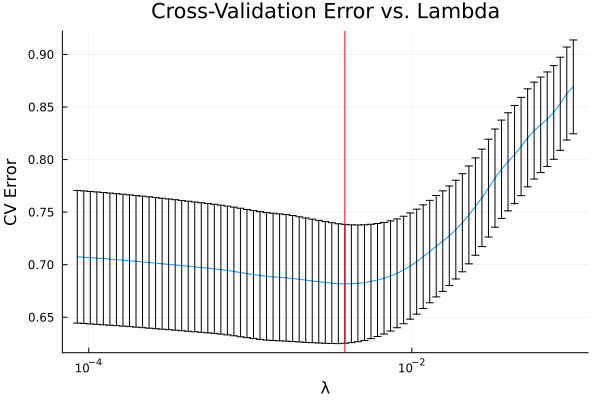

In [29]:
StatsPlots.plot(cv.lambda, cv.meanloss, xscale=:log10, legend=false, yerror=cv.stdloss, xlabel="λ", ylabel="CV Error")
# add the line at minimum cv_error
vline!([lambdamin(cv)], color = :red)
title!("Cross-Validation Error vs. Lambda")

***Model Performances***

In [30]:
# best model with the lowest lambda
fit = glmnet(X_train, y_train, lambda = [best_lambda])

Logistic GLMNet Solution Path (1 solutions for 51 predictors in 110 passes):
─────────────────────────────
     df   pct_dev           λ
─────────────────────────────
[1]  35  0.312803  0.00384921
─────────────────────────────

In [31]:
# use fitted model to make predictions
probs = GLMNet.predict(fit, X_train, outtype = :prob) |> vec;

In [32]:
yhat = ifelse.(probs .>= 0.8, "Yes", "No")
# Accuracy of Train Model
100 * mean(yhat .== y_train)

85.32555879494656

In [33]:
# Accuracy of Test Model
yhat_test = ifelse.(GLMNet.predict(fit, X_test) .>= 0.8, "Yes", "No")
100 * mean(yhat_test .== y_test)

85.26077097505669

***Best Model***

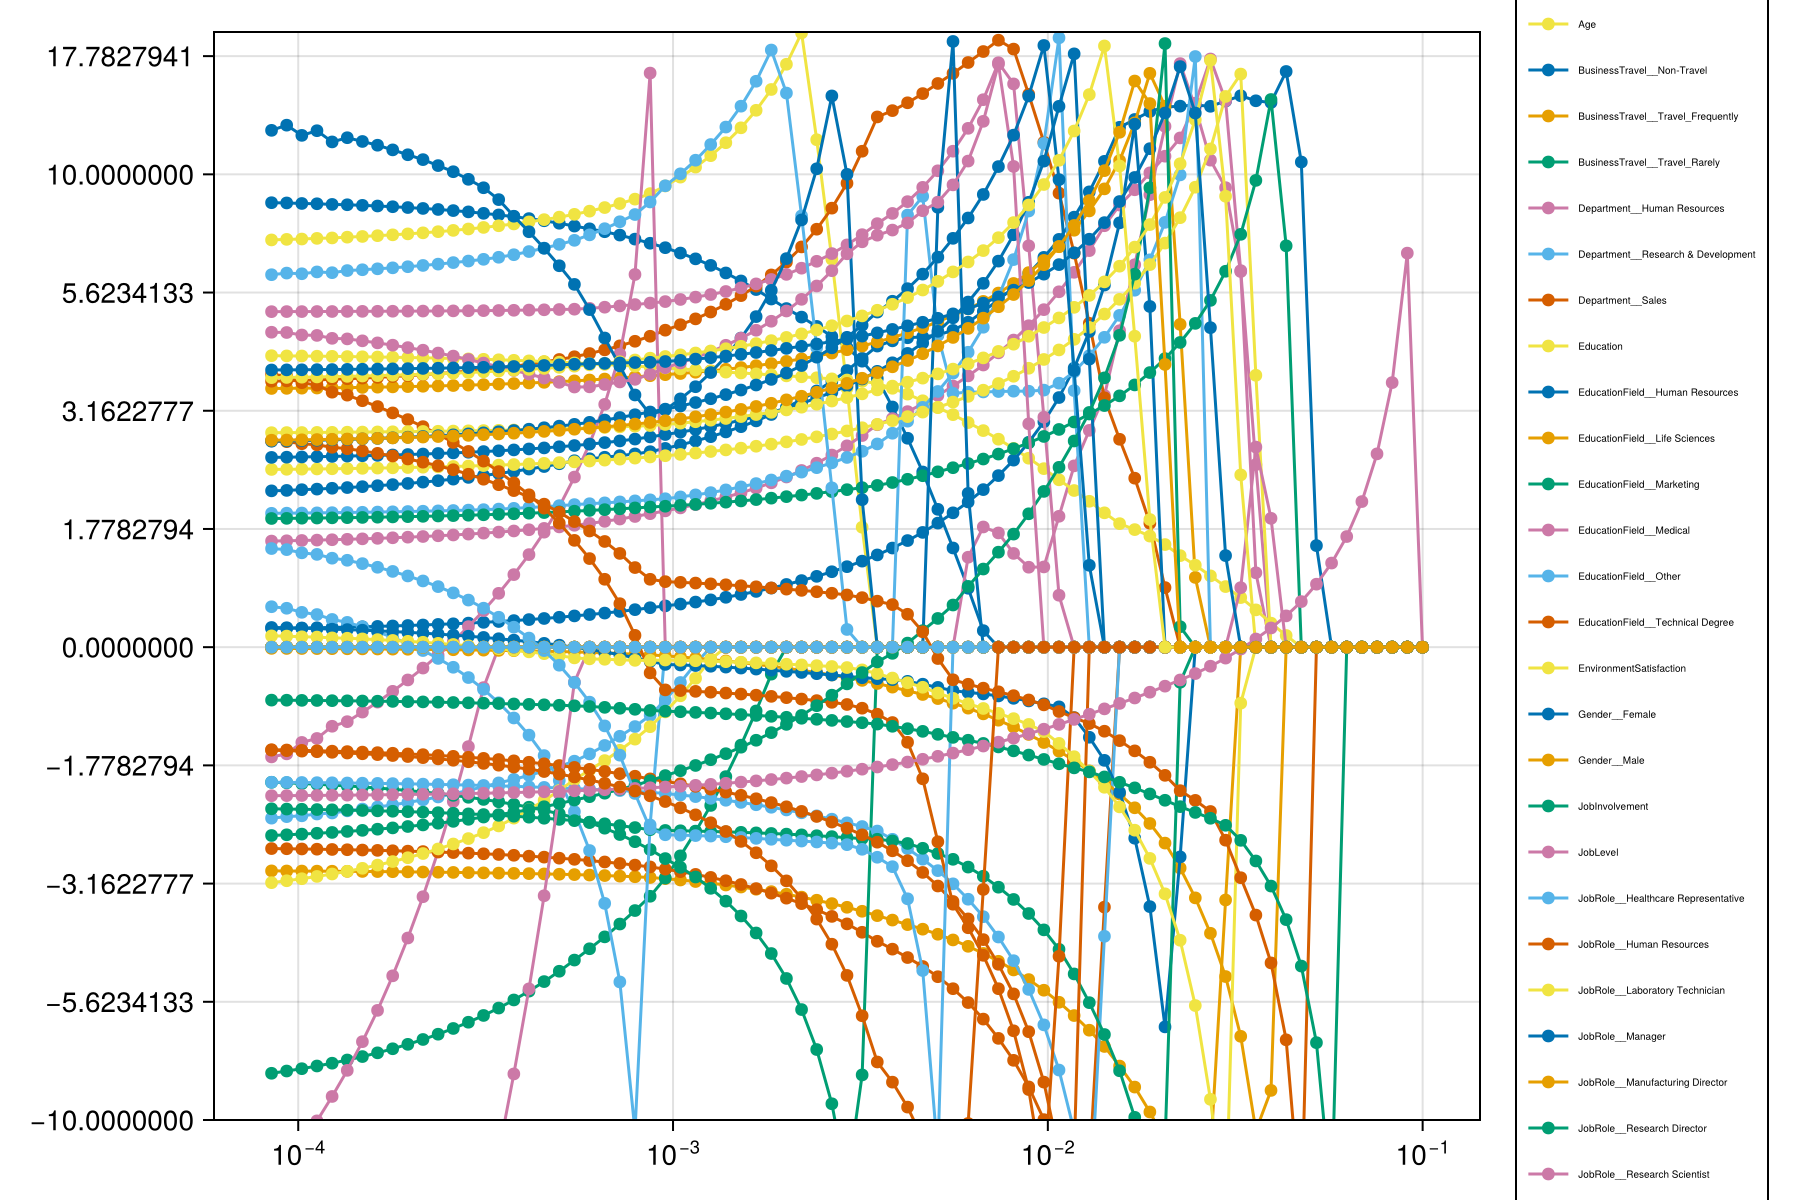

In [34]:
# put lambdas on x-axis
xs = cv.lambda

# we will plot coefficients as a function of lambda
betas = cv.path.betas

# initalize empty figure
fig = Figure(size = (900, 600))
ax = Axis(fig[1,1],
    xscale = log10,
    yscale = Makie.Symlog10(0.05),
    yticks = LogTicks(LinearTicks(11)),
    limits = (nothing, (-10, 20)),
)

predictors = select(update_IBM, Not([:Attrition]))
# label the path for each coefficient
predictors = names(predictors)

for i in axes(betas, 1)
    ys = betas[i, :]
    scatterlines!(ax, xs, ys, label = "$(predictors[i])")
end
Legend(fig[1,2], ax, labelsize=5)
fig

In [35]:
# DataFrame with all variables with corresponding coefficients
cv_df = DataFrame(predictors = predictors,
                coef = GLMNet.coef(cv))

# Filter DataFrame to select only columns where coef != 0.0
filter!(row -> row.coef != 0.0, cv_df)

@show cv_df.predictors

cv_df.predictors = ["DailyRate", "DistanceFromHome", "NumCompaniesWorked", "TotalWorkingYears", "TrainingTimesLastYear", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager", "Age", "BusinessTravel__Non-Travel", "BusinessTravel__Travel_Frequently", "EducationField__Human Resources", "EducationField__Marketing", "EducationField__Medical", "EducationField__Other", "EducationField__Technical Degree", "EnvironmentSatisfaction", "Gender__Female", "Gender__Male", "JobInvolvement", "JobRole__Human Resources", "JobRole__Laboratory Technician", "JobRole__Research Director", "JobRole__Research Scientist", "JobRole__Sales Executive", "JobRole__Sales Representative", "JobSatisfaction", "MaritalStatus__Divorced", "MaritalStatus__Single", "OverTime__No", "OverTime__Yes", "PerformanceRating", "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance"]


35-element Vector{String}:
 "DailyRate"
 "DistanceFromHome"
 "NumCompaniesWorked"
 "TotalWorkingYears"
 "TrainingTimesLastYear"
 "YearsInCurrentRole"
 "YearsSinceLastPromotion"
 "YearsWithCurrManager"
 "Age"
 "BusinessTravel__Non-Travel"
 ⋮
 "JobSatisfaction"
 "MaritalStatus__Divorced"
 "MaritalStatus__Single"
 "OverTime__No"
 "OverTime__Yes"
 "PerformanceRating"
 "RelationshipSatisfaction"
 "StockOptionLevel"
 "WorkLifeBalance"

In [36]:
# filter selected variables in the best model
final_IBM = select(combined_IBM, [:Attrition, :DailyRate, :DistanceFromHome, :NumCompaniesWorked, :TotalWorkingYears, 
                                  :TrainingTimesLastYear, :YearsInCurrentRole, :YearsSinceLastPromotion, :YearsWithCurrManager, :Age, :BusinessTravel, 
                                  :EducationField, :EnvironmentSatisfaction, :Gender, :JobInvolvement, :JobRole, :JobSatisfaction, 
                                  :MaritalStatus, :OverTime, :PerformanceRating, :RelationshipSatisfaction, :StockOptionLevel, :WorkLifeBalance])
                                  
final_IBM.Attrition = map(x -> x == "Yes" ? 1 : 0, final_IBM.Attrition)
first(final_IBM, 5)

5×23 DataFrame
 Row │ Attrition  DailyRate  DistanceFromHome  NumCompaniesWorked  TotalWorkin ⋯
     │ Int64      Float64    Float64           Float64             Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │         1       0.74             -1.01                2.12              ⋯
   2 │         0      -1.3              -0.15               -0.68
   3 │         1       1.41             -0.89                1.32
   4 │         0       1.46             -0.76               -0.68
   5 │         0      -0.52             -0.89                2.52              ⋯
                                                              19 columns omitted

#### Logistic Regression

***Original Data - Full Model***

In [101]:
# Set the random seed to 206
Random.seed!(206)

# Specify the proportion of data to use for training
train_proportion = 0.7

# Split the data into train and test sets
(train, test) = splitobs(shuffleobs(IBM_Employee), at = train_proportion);

In [102]:
#full model for 31 variables
fullmodel = @formula(Attrition ~ Age+BusinessTravel+DailyRate+Department+DistanceFromHome
    + Education+EducationField+EnvironmentSatisfaction+Gender+HourlyRate
    + JobInvolvement+ JobLevel+ JobRole+JobSatisfaction+MaritalStatus+MonthlyIncome
    +MonthlyRate+NumCompaniesWorked+OverTime+PercentSalaryHike+PerformanceRating
    +RelationshipSatisfaction+StockOptionLevel+TotalWorkingYears+TrainingTimesLastYear+WorkLifeBalance
    +YearsAtCompany+YearsInCurrentRole+YearsSinceLastPromotion+YearsWithCurrManager)

# Fit the logistic regression model
logit = glm(fullmodel, train, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Attrition ~ 1 + Age + BusinessTravel + DailyRate + Department + DistanceFromHome + Education + EducationField + EnvironmentSatisfaction + Gender + HourlyRate + JobInvolvement + JobLevel + JobRole + JobSatisfaction + MaritalStatus + MonthlyIncome + MonthlyRate + NumCompaniesWorked + OverTime + PercentSalaryHike + PerformanceRating + RelationshipSatisfaction + StockOptionLevel + TotalWorkingYears + TrainingTimesLastYear + WorkLifeBalance + YearsAtCompany + YearsInCurrentRole + YearsSinceLastPromotion + YearsWithCurrManager

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.    Std. Error      z  Pr(>|z|)      Lower 95%     Upper 95%
──────

In [103]:
# Predict the target variable on test data 
prediction = GLM.predict(logit,test)

# Converting probability score to classes with cut of score of 0.8
prediction_class = [if i < 0.8 0 else 1 end for i in prediction]

# Create a dataset with actual and predicted Attrition
prediction_df = DataFrame(y_actual = test.Attrition, 
						y_predicted = prediction_class, 
						prob_predicted = prediction); 

prediction_df.correctly_classified = prediction_df.y_actual .== prediction_df.y_predicted

# View of the actual vs. prediction data
first(prediction_df, 10)

10×4 DataFrame
 Row │ y_actual  y_predicted  prob_predicted  correctly_classified 
     │ Int64     Int64        Float64?        Bool                 
─────┼─────────────────────────────────────────────────────────────
   1 │        0            0     0.0348363                    true
   2 │        0            0     0.0216423                    true
   3 │        1            0     0.438811                    false
   4 │        0            0     0.0603128                    true
   5 │        0            0     0.0329352                    true
   6 │        0            0     0.301807                     true
   7 │        1            0     0.453302                    false
   8 │        0            0     0.000135501                  true
   9 │        0            0     0.169889                     true
  10 │        0            0     0.00999521                   true

In [104]:
# Accuracy Score 
accuracy_score = GLM.mean(prediction_df.correctly_classified)*100

84.58049886621315

In [74]:
confusion_matrix = MLBase.roc(prediction_df.y_actual, prediction_df.y_predicted)

ROCNums{Int64}
  p = 76
  n = 365
  tp = 8
  tn = 365
  fp = 0
  fn = 68


In [76]:
tp = 8
tn = 365
fp = 0
fn = 68

# Create a DataFrame
confusion_matrix = DataFrame(
    Class = ["Yes", "No"],
    Yes = [tp, fn],
    No = [fp, tn]
)

# Print the DataFrame
display(confusion_matrix)

2×3 DataFrame
 Row │ Class   Yes    No    
     │ String  Int64  Int64 
─────┼──────────────────────
   1 │ Yes         8      0
   2 │ No         68    365

***Selected Data from Lasso - Full Model***

In [43]:
# Set the random seed to 206
Random.seed!(206)

# Specify the proportion of data to use for training
train_proportion = 0.7

# Split the data into train and test sets
(train, test) = splitobs(shuffleobs(final_IBM), at = train_proportion);

In [44]:
# Define the formula
fm = @formula(Attrition ~ Age+BusinessTravel+DailyRate+DistanceFromHome+EducationField+EnvironmentSatisfaction+Gender
                         +JobInvolvement+JobRole+JobSatisfaction+MaritalStatus+NumCompaniesWorked+OverTime+PerformanceRating
                         +RelationshipSatisfaction+StockOptionLevel+TotalWorkingYears+TrainingTimesLastYear+ WorkLifeBalance
                         +YearsInCurrentRole+YearsSinceLastPromotion+YearsWithCurrManager)

# Fit the logistic regression model
logit = glm(fm, train, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Attrition ~ 1 + Age + BusinessTravel + DailyRate + DistanceFromHome + EducationField + EnvironmentSatisfaction + Gender + JobInvolvement + JobRole + JobSatisfaction + MaritalStatus + NumCompaniesWorked + OverTime + PerformanceRating + RelationshipSatisfaction + StockOptionLevel + TotalWorkingYears + TrainingTimesLastYear + WorkLifeBalance + YearsInCurrentRole + YearsSinceLastPromotion + YearsWithCurrManager

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────
                                        Coef.  Std. Error      z  Pr(>|z|)   Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                         0.

In [45]:
# Predict the target variable on test data 
prediction = GLM.predict(logit,test)

# Converting probability score to classes with cut of score of 0.8
prediction_class = [if i < 0.8 0 else 1 end for i in prediction]

# Create a dataset with actual and predicted Attrition
prediction_df = DataFrame(y_actual = test.Attrition, 
						y_predicted = prediction_class, 
						prob_predicted = prediction); 

prediction_df.correctly_classified = prediction_df.y_actual .== prediction_df.y_predicted

# View of the actual vs. prediction data
first(prediction_df, 10)

10×4 DataFrame
 Row │ y_actual  y_predicted  prob_predicted  correctly_classified 
     │ Int64     Int64        Float64?        Bool                 
─────┼─────────────────────────────────────────────────────────────
   1 │        0            0     0.0428125                    true
   2 │        0            0     0.0189714                    true
   3 │        1            0     0.458627                    false
   4 │        0            0     0.0470156                    true
   5 │        0            0     0.0401881                    true
   6 │        0            0     0.283752                     true
   7 │        1            0     0.410613                    false
   8 │        0            0     0.000658828                  true
   9 │        0            0     0.143023                     true
  10 │        0            0     0.00740846                   true

In [46]:
# Accuracy Score 
accuracy_score = GLM.mean(prediction_df.correctly_classified)*100

84.12698412698413

In [47]:
confusion_matrix = MLBase.roc(prediction_df.y_actual, prediction_df.y_predicted)

ROCNums{Int64}
  p = 76
  n = 365
  tp = 6
  tn = 365
  fp = 0
  fn = 70


In [48]:
tp = 6
tn = 365
fp = 0
fn = 70

# Create a DataFrame
confusion_matrix = DataFrame(
    Class = ["Yes", "No"],
    Yes = [tp, fn],
    No = [fp, tn]
)

# Print the DataFrame
display(confusion_matrix)

2×3 DataFrame
 Row │ Class   Yes    No    
     │ String  Int64  Int64 
─────┼──────────────────────
   1 │ Yes         6      0
   2 │ No         70    365

#### Classification

***KNNClassifier, LDA, NeuralNetworkClassifier, MultinomialClassifier Models***

In [49]:
# Predict and Response variables
X = select(update_IBM, cv_df.predictors)
y = categorical(String.(update_IBM[!, :Attrition]), levels = ["Yes", "No"])

# split train and test data
train, test = partition(eachindex(y), 0.7, shuffle = true, rng = 206);

In [50]:
# KNNClassifier, LDA, NeuralNetworkClassifier, MultinomialClassifier Models

KNNClassifier = @load KNNClassifier verbosity = 0
LDA = @load LDA verbosity = 0
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg = MLJFlux verbosity = 0
MultinomialClassifier = @load MultinomialClassifier verbosity = 0

model_list = [
    KNNClassifier(K = 5), # use nearest 5-neighbors to make predictions
    LDA(),
    NeuralNetworkClassifier(epochs = 100, batch_size = 10),
    MultinomialClassifier()
]

4-element Vector{Probabilistic}:
 KNNClassifier(K = 5, …)
 LDA(method = gevd, …)
 NeuralNetworkClassifier(builder = Short(n_hidden = 0, …), …)
 MultinomialClassifier(lambda = 2.220446049250313e-16, …)

In [51]:
# initialized performance vectors
acc = Float64[] # accuracy()
pre = Float64[] # multiclass_precision()
rec = Float64[] # multiclass_recall()
f1s = Float64[] # f1score()
mat = [];        # confusion_matrix()

***Fit each Model and Evaluate `Accuracy, Precision, Recall, F1, ConfusionMatrix`***

In [ ]:
# Fit each model and evaluate it based on the test test
for clf in model_list
    # Create a pipeline model that
    # (1) standardizes numeric data,
    # (2) expands :species to 3 columns, each indicating membership in one of the 3 groups,
    # (3) then fits a classifier.
    model = Pipeline(Standardizer(), OneHotEncoder(), clf)

    # Fit the model onto the training set
    mach = machine(model, X, y)
    fit!(mach, rows = train, verbosity = 0)

    # Make predictions on the test set
    yhat = MLJ.predict(mach, rows = test)

    # Evaluate the model on the test set using selected metrics
    #
    # NOTES:
    #
    #   - MLJ.predict() may give probabilistic predictions. Use mode() to collapse to a concrete target.
    #   - An evaluation metric F() always accepts inputs as F(fitted, observed).
    #
    push!(acc, accuracy(mode.(yhat), y[test]))
    push!(pre, multiclass_precision(mode.(yhat), y[test]))
    push!(rec, multiclass_recall(mode.(yhat), y[test]))
    push!(f1s, multiclass_f1score(mode.(yhat), y[test]))
    push!(mat, ConfusionMatrix(levels = levels(y))(mode.(yhat), y[test]))
end

In [53]:
# ConfusionMatrix for each model
mat[1]  # KNNClassifier

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│ Yes  │  No  │
├─────────┼──────┼──────┤
│   Yes   │  8   │  4   │
├─────────┼──────┼──────┤
│   No    │  64  │ 365  │
└─────────┴──────┴──────┘


In [54]:
mat[2]  # LDA

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│ Yes  │  No  │
├─────────┼──────┼──────┤
│   Yes   │  55  │  72  │
├─────────┼──────┼──────┤
│   No    │  17  │ 297  │
└─────────┴──────┴──────┘


In [55]:
mat[3]  # NeuralNetworkClassifier

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│ Yes  │  No  │
├─────────┼──────┼──────┤
│   Yes   │  18  │  3   │
├─────────┼──────┼──────┤
│   No    │  54  │ 366  │
└─────────┴──────┴──────┘


In [56]:
mat[4]  # MultinomialClassifier

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│ Yes  │  No  │
├─────────┼──────┼──────┤
│   Yes   │  24  │  8   │
├─────────┼──────┼──────┤
│   No    │  48  │ 361  │
└─────────┴──────┴──────┘


In [57]:
# Perform Accuracy, Precision, Recall, F1 Results
results = DataFrame(
    Model = typeof.(model_list),
    Accuracy = acc,
    Precision = pre,
    Recall = rec,
    F1 = f1s
)

4×5 DataFrame
 Row │ Model                              Accuracy  Precision  Recall    F1    ⋯
     │ DataType                           Float64   Float64    Float64   Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ KNNClassifier                      0.845805   0.758741  0.550136  0.552 ⋯
   2 │ LDA                                0.798186   0.689465  0.784383  0.711
   3 │ NeuralNetworkClassifier{Short, t…  0.870748   0.864286  0.620935  0.657
   4 │ MultinomialClassifier              0.873016   0.81632   0.655827  0.694
                                                                1 column omitted